# Vector Calculus

> *Quick Note*  
> Some assertions (via `assert`) are made to check if the matrix dimensions are at least as expected.

In [1]:
# Provide standard deviation and mean
user_mean = 1.5
user_std = 3

Load the needed libraries.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Data Preparation

This function generates the samples. It takes in some num_data random samples from a 1D Gaussian, and performs binning with num_samples.

Some assertion is done to check if at least the lengths of the variables check out. This type of simple assertion is also done on other functions.

In [3]:
def generate_samples(data_mean, data_std, num_data=1000000, num_samples=1000):
  """Return a 1D array of num_samples with mean and std"""

  data_points = np.random.normal(data_mean, data_std, num_data)
  hist, edges = np.histogram(data_points, num_samples, density=True)
  
  plt.plot(edges[:-1], hist, 'o', color='b', label='Observation')

  plt.show()

  assert len(data_points) == num_data
  assert len(hist) == num_samples

  return (edges[:-1], hist)

This function splits the dataset into train_split of the dataset for the train set, and the remaining (1 - train_split) for the test set.

Both the train and test sets are said to be independent and identically distributed random variables as the samples in these sets come from the same probability distribution (the earlier provided 1D Gaussian), and are not dependent on other values. The latter comes as an effect of randomly selecting samples.

In [4]:
def split_dataset(dataset, train_split=0.9):
  """Return dataset assigned to either the train and test sets"""

  temp_data = np.copy(dataset)
  np.random.shuffle(temp_data)

  sample, label = temp_data

  x_train = sample[:(int(train_split * len(sample)))]
  y_train = label[:(int(train_split * len(label)))]
  x_test = sample[(int(train_split * len(sample))):]
  y_test = label[(int(train_split * len(label))):]

  x_train = np.expand_dims(x_train, axis=0)
  y_train = np.expand_dims(y_train, axis=0)
  x_test = np.expand_dims(x_test, axis=0)
  y_test = np.expand_dims(y_test, axis=0)

  assert x_train.shape == (1, len(sample) * train_split)
  assert y_train.shape == (1, len(label) * train_split)
  assert x_test.shape == (1, round(len(sample) * (1 - train_split)))
  assert y_test.shape == (1, round(len(label) * (1 - train_split)))

  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, and y_test should all have the dimensions of (input_size, number_of_samples). In this case, it is (1, 900) or (1, 100).

This function initializes the parameters.

Biases are zero initialized with the shape (layer_dims[n], 1) where n is the nth layer, and layer_dims[n] would be the dimension for the (hidden) layer.

Weights are initialized as a Gaussian distribution with zero mean and 0.01 std. It's also good to note that the weights are small.

A dict is returned so that it will be easier to iterate through, and also in the hopes that it might be translatable/understood in equation form when used.

With a 3-layer neural network, there are (1 input layer,) 2 hidden layers and 1 output layer.

In [5]:
def init_parameters(net_arch):
  """Return weights and biases for layers
  
  Argument:
    * net_arch: Contains a description of the layers
  """

  parameters = {}

  for layer_n, layer_desc in enumerate(net_arch):
    parameters[f"b{layer_n}"] = np.zeros((layer_desc["output_dim"], 1))
    assert parameters[f"b{layer_n}"].shape == (layer_desc["output_dim"], 1)

    parameters[f"w{layer_n}"] = np.random.normal(0, 0.01, (layer_desc["output_dim"], layer_desc["input_dim"]))
    assert parameters[f"w{layer_n}"].shape == (layer_desc["output_dim"], layer_desc["input_dim"])
  
  return parameters

## Forward Propagation

The functions below are for an easier and abstracted calculation for sigmoid and ReLU.

In [6]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

Equations used in forward propagation are:

- $Z_n = W_{n-1}A_{n-1} + b_{n-1}$, where $Z_n$ is the linear function passed to the activation function, $W_{n-1}$ are the weights from the previous layer, $A_{n-1}$ is the activation from the previous layer, $b_{n-1}$ are the biases from the previous layer, and $n$ denotes the number of layers in the network.
- $A_n = \sigma_n(Z_n)$. A sigmoid is used as the activation function for the last layer.
- $A_{n-1} = ReLU(Z_{n-1})$. ReLU is used as the activation function for all of the other layers.

A cache is implemented to store variables computed for each layer. These might be useful during backpropagation.

In [7]:
def forwardprop(X, WB, num_layer):
  """Return the last activation function and the cache dict in preparation for backprop"""

  caches = {}

  a = X

  for n_layer in range(1, num_layer + 1):
    prev_a = a
    prev_w = WB[f"w{n_layer - 1}"]
    prev_b = WB[f"b{n_layer - 1}"]

    z = np.dot(prev_w, prev_a) + prev_b
    if n_layer < num_layer:
      a = relu(z)
    else:
      a = sigmoid(z)
    
    caches[f"layer_{n_layer}"] = {
        "prev_a": prev_a,
        "prev_w": prev_w,
        "prev_b": prev_b,
        "z": z
    }
  
  assert a.shape == (1, X.shape[1])

  return a, caches

Quick note that `z` is used as the basis for the cache keys, e.g., for `layer_3` in `caches`, what is present are: $z_3$, $a_2$, $W_2$, and $b_2$. This type of grouping together of variables can make it easier to do backpropagation.

In [8]:
# a_last, activation_caches = forwardprop(x_train, parameters, len(parameters) // 2)

## Cost

Mean Squared Error has the following formula:

$MSE = \frac{1}{m}\sum_{i=0}^m(Y_i-\hat{Y}_i)^2$

$Y$ are the labels, $\hat{Y}$ are the predictions, and $m$ is the number of samples.

This will be used to check how close or far off the prediction is from the ground truth/label.

In [9]:
def mse_loss(gt_y, y):
  m = y.shape[1]
  cost = np.mean(np.power(gt_y - y, 2))
  return cost

## Backpropagation

With backpropagation, the interest is in decreasing the cost between the predictions and the labels. Backprop starts at the last layer, and will end at the first layer. Computations regarding the backprop are shown below.

### General

In general, what are needed are $\frac{\partial{L}}{\partial{W_{n-1 ... 0}}}$ and $\frac{\partial{L}}{\partial{b_{n-1 ... 0}}}$, where $L$ is the loss/cost function, $W$ are the weights, and $b$ are the biases. The weights and biases are adjusted in order to reduce the value of the cost function.

### From the Output to Hidden Layer 2

What is being sought are $\frac{\partial{L}}{\partial{W_2}}$ and $\frac{\partial{L}}{\partial{b_2}}$.

\begin{align}
\frac{\partial{L}}{\partial{W_2}} &= \frac{\partial{L}}{\partial{Z_3}} \frac{\partial{Z_3}}{\partial{W_{2}}}  \tag{1}\\
\frac{\partial{L}}{\partial{b_2}} &= \frac{\partial{L}}{\partial{Z_3}} \frac{\partial{Z_3}}{\partial{b_{2}}} \tag{2}
\end{align}

The common term $\frac{\partial{L}}{\partial{Z_3}}$ can be solved as shown below:

\begin{align}
\frac{\partial{L}}{\partial{Z_3}} &= \frac{\partial{L}}{\partial{A_3}} \frac{\partial{A_3}}{\partial{Z_3}} \tag{3} \\
\frac{\partial{L}}{\partial{A_3}} &= \frac{\partial{(\frac{1}{m}\sum_{i=0}^m(Y_i-\hat{Y}_i)^2)}}{\partial{A_3}} = \frac{\partial{(\frac{1}{m}\sum_{i=0}^m(Y-A_3)^2)}}{\partial{A_3}} \\
\frac{\partial{L}}{\partial{A_3}} &= -\frac{2}{m}(Y - A_3) \tag{4} \\
\frac{\partial{A_3}}{\partial{Z_3}} &= \frac{\partial({\sigma({Z_3}))}}{\partial{Z_3}} \\
\frac{\partial{A_3}}{\partial{Z_3}} &= \sigma({Z_3})(1-\sigma({Z_3})) \tag{5} \\
\frac{\partial{L}}{\partial{Z_3}} &= ( -\frac{2}{m}(Y - A_3))(\sigma({Z_3})(1-\sigma({Z_3}))) \tag{6 (4, 5 to 3)}
\end{align}

The term $\frac{\partial{Z_3}}{\partial{W_{2}}}$ can be solved as shown below:

\begin{align}
\frac{\partial{Z_3}}{\partial{W_{2}}} &= \frac{\partial(W_{2}A_{2}+b_{2})}{\partial{W_{2}}} \\
\frac{\partial{Z_3}}{\partial{W_{2}}} &= A_{2} \tag{7} \\
\end{align}

Lastly, the term $\frac{\partial{Z_3}}{\partial{b_{2}}}$ can be solved as shown below:

\begin{align}
\frac{\partial{Z_3}}{\partial{b_{2}}} &= \frac{\partial(W_{2}A_{2}+b_{2})}{\partial{b_{2}}} \\
\frac{\partial{Z_3}}{\partial{b_{2}}} &= 1 \tag{8} \\
\end{align}

Combining all of these yield:

\begin{align}
\frac{\partial{L}}{\partial{W_2}} &= (-\frac{2}{m}(Y - A_3))(\sigma({Z_3})(1-\sigma({Z_3}))) A_{2}  \tag{9 (6, 7 to 1)}\\
\frac{\partial{L}}{\partial{b_2}} &= (-\frac{2}{m}(Y - A_3))(\sigma({Z_3})(1-\sigma({Z_3}))) \tag{10 (6, 8 to 2)}
\end{align}

### From Hidden Layer 2 to Hidden Layer 1

What is being sought are $\frac{\partial{L}}{\partial{W_1}}$ and $\frac{\partial{L}}{\partial{b_1}}$.

\begin{align}
\frac{\partial{L}}{\partial{W_1}} &= \frac{\partial{L}}{\partial{Z_2}} \frac{\partial{Z_2}}{\partial{W_1}}  \tag{11}\\
\frac{\partial{L}}{\partial{b_1}} &= \frac{\partial{L}}{\partial{Z_2}} \frac{\partial{Z_2}}{\partial{b_1}} \tag{12}
\end{align}

Following the computations from earlier, $\frac{\partial{Z_2}}{\partial{W_1}}$ and $\frac{\partial{Z_2}}{\partial{b_1}}$ can already be computed.

\begin{align}
\frac{\partial{Z_2}}{\partial{W_1}} &= A_1 \tag{13} \\
\frac{\partial{Z_2}}{\partial{b_1}} &= 1 \tag{14}
\end{align}

The common term $\frac{\partial{L}}{\partial{Z_2}}$ can be solved as shown below:

\begin{align}
\frac{\partial{L}}{\partial{Z_2}} &= \frac{\partial{L}}{\partial{Z_3}}\frac{\partial{Z_3}}{\partial{A_2}}\frac{\partial{A_2}}{\partial{Z_2}} \tag{15} \\
\frac{\partial{Z_3}}{\partial{A_2}} &= \frac{\partial{(W_2 A_2 + b_2)}}{A_2} = W_2 \tag{16} \\
\frac{\partial{A_2}}{\partial{Z_2}} &= \frac{\partial{(ReLU(Z_2))}}{\partial{Z_2}} \tag{17} \\
\frac{\partial{L}}{\partial{Z_2}} &= \frac{\partial{L}}{\partial{Z_3}}W_2\frac{\partial{(ReLU(Z_2))}}{\partial{Z_2}} \tag{18 (16, 17 to 15)}
\end{align}

Combining all of those yield:

\begin{align}
\frac{\partial{L}}{\partial{W_1}} &= \frac{\partial{L}}{\partial{Z_3}}W_2\frac{\partial{(ReLU(Z_2))}}{\partial{Z_2}} A_1  \tag{19 (18, 13 to 11)} \\
\frac{\partial{L}}{\partial{b_1}} &= \frac{\partial{L}}{\partial{Z_3}}W_2\frac{\partial{(ReLU(Z_2))}}{\partial{Z_2}} \tag{20 (18, 14 to 12)} \\
\end{align}

### From Hidden Layer 1 to the Input

The equations for this last stage of the backpropagation are derived as follows:

\begin{align}
\frac{\partial{L}}{\partial{W_0}} &= \frac{\partial{L}}{\partial{Z_1}} \frac{\partial{Z_1}}{\partial{W_0}} = \frac{\partial{L}}{\partial{Z_1}}x  \tag{21}\\
\frac{\partial{L}}{\partial{b_0}} &= \frac{\partial{L}}{\partial{Z_1}} \frac{\partial{Z_1}}{\partial{b_0}} = \frac{\partial{L}}{\partial{Z_1}} \tag{22}
\end{align}

From the derivation of the backprop, it can be noted that it might be a good idea to store the derived gradients for future use. In the same way that `caches` was previously used to store forwardprop results, `grads` will be used to store backprop results that might be used.

The functions below are for an easier and abstracted calculation for the derivatives of sigmoid and ReLU.

In [10]:
def d_sigmoid(x):
  return sigmoid(x) * (1 - sigmoid(x))

def d_relu(da, z):
  x_copy = da.copy()
  x_copy[z > 0] = 1
  x_copy[z <= 0] = 0

  return x_copy

In [11]:
def backprop(X, Y, a, caches):
  num_layer = len(caches)
  grads = {}

  # Output to Hidden Layer 2
  len_a3 = a.shape[1]
  d_a3 = (-2 * (Y - a))
  d_z3 = d_sigmoid(caches["layer_3"]["z"])
  d_l3 = d_a3 * d_z3
  grads["dw2"] = np.dot(d_l3, caches["layer_3"]["prev_a"].T) / a.shape[1]
  grads["db2"] = np.sum(d_l3, axis=1, keepdims=True) / a.shape[1]

  assert caches["layer_3"]["prev_w"].shape == grads["dw2"].shape
  assert caches["layer_3"]["prev_b"].shape == grads["db2"].shape

  # Hidden Layer 2 to Hidden Layer 1
  d_a2 = np.dot(caches["layer_3"]["prev_w"].T, d_l3)
  d_z2 = d_relu(d_a2, caches["layer_2"]["z"])
  d_l2 = d_a2 * d_z2
  grads["dw1"] = np.dot(d_l2, caches["layer_2"]["prev_a"].T) / caches["layer_2"]["prev_a"].shape[1]
  grads["db1"] = np.sum(d_l2, axis=1, keepdims=True) / caches["layer_2"]["prev_a"].shape[1]

  assert caches["layer_2"]["prev_w"].shape == grads["dw1"].shape
  assert caches["layer_2"]["prev_b"].shape == grads["db1"].shape

  # Hidden Layer 1 to Input
  d_a1 = np.dot(caches["layer_2"]["prev_w"].T, d_l2)
  d_z1 = d_relu(d_a1, caches["layer_1"]["z"])
  d_l1 = d_a1 * d_z1
  grads["dw0"] = np.dot(d_l1, caches["layer_1"]["prev_a"].T) / caches["layer_1"]["prev_a"].shape[1]
  grads["db0"] = np.sum(d_l1, axis=1, keepdims=True) / caches["layer_1"]["prev_a"].shape[1]

  assert caches["layer_1"]["prev_w"].shape == grads["dw0"].shape
  assert caches["layer_1"]["prev_b"].shape == grads["db0"].shape

  return grads

In [12]:
# wb_grads = backprop(x_train, y_train, a_last, activation_caches)

In [13]:
def update_params(WB, grads, learning_rate=0.1):
  num_layer = len(WB) // 2

  for n_layer in range(num_layer):
    WB[f"w{n_layer}"] = WB[f"w{n_layer}"] - learning_rate * grads[f"dw{n_layer}"]
    WB[f"b{n_layer}"] = WB[f"b{n_layer}"] - learning_rate * grads[f"db{n_layer}"]
  
  return WB

In [14]:
def train(X, Y, net_out, learning_rate=0.1, epochs=20):
  params = init_parameters(net_out)

  for epoch in range(epochs):
    a_last, activation_caches = forwardprop(X, params, len(params) // 2)
    cost = mse_loss(Y, a_last)
    print(f"Epoch[{epoch + 1}] cost: {cost}")
    wb_grads = backprop(X, Y, a_last, activation_caches)
    params = update_params(params, wb_grads, learning_rate)
  
  return params

A dict outlining the network is used as a form of cohesion check, and something to refer to when checking out the layer dimensions.

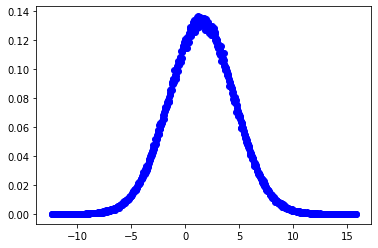

Epoch[1] cost: 0.21426884750996497
Epoch[2] cost: 0.20898482480325511
Epoch[3] cost: 0.20383443339452084
Epoch[4] cost: 0.1988166643336745
Epoch[5] cost: 0.19393011234420737
Epoch[6] cost: 0.1891732617824965
Epoch[7] cost: 0.1845446873108884
Epoch[8] cost: 0.18004251334520197
Epoch[9] cost: 0.17566468439557986
Epoch[10] cost: 0.17140894966015757
Epoch[11] cost: 0.16727301575078007
Epoch[12] cost: 0.1632549531107265
Epoch[13] cost: 0.1593522986730244
Epoch[14] cost: 0.15556249088141205
Epoch[15] cost: 0.1518830308568421
Epoch[16] cost: 0.14831124535667697
Epoch[17] cost: 0.14484443105846045
Epoch[18] cost: 0.1414799160837438
Epoch[19] cost: 0.1382149859830438
Epoch[20] cost: 0.13504689947536944


In [15]:
dataset = generate_samples(user_mean, user_std)
x_train, y_train, x_test, y_test = split_dataset(dataset)

network_outline = [
  { "input_dim": x_train.shape[0], "output_dim": 64 },
  { "input_dim": 64, "output_dim": 64 },
  { "input_dim": 64, "output_dim": 1 }
]

parameters = train(x_train, y_train, network_outline)

## Evaluation

Below are graphs that help in analyzing the predictions. A `predict` function wraps the forward propagation function, but this time with the parameters found after training.

In [16]:
def predict(X, params):
  a_last, _ = forwardprop(X, params, len(params) // 2)

  return a_last

The lines of code below compare the mean and standard deviation of the ground truth versus that of the predicted.

The results of the test set seem to be better than the results of the train set as the mean and std of the acquired data is closer, but this appears to be inconclusive as the test set appears to mirror less the shape of a Gaussian distribution, but this is an interesting observation.

Even in varying the number of epochs and the learning rate, the predictions on the trainset maintain the same mean and standard deviation, but it can be viewed in the graphs below that the shape of the ground truth and predicted appear to follow a particular pattern.

In [17]:
# Check train
y_train_res = predict(x_train, parameters)

mid_train = 0.5 * (x_train[0][1:] + x_train[0][:-1])
mid_train = np.expand_dims(mid_train, axis=0)
mean_train = np.average(mid_train, weights=y_train[0][:-1], axis=1)
var_train = np.average((mid_train - mean_train) ** 2, weights=y_train[0][:-1], axis=1)
std_train = np.sqrt(var_train)

pred_mean_train = np.average(mid_train, weights=y_train_res[0][:-1], axis=1)
pred_var_train = np.average((mid_train - pred_mean_train) ** 2, weights=y_train_res[0][:-1], axis=1)
pred_std_train = np.sqrt(pred_var_train)

print(f"[Train Mean] GT({mean_train[0]}), Pred({pred_mean_train[0]})")
print(f"[Train STD] GT({std_train[0]}), Pred({pred_std_train[0]})")

# Check test
y_test_res = predict(x_test, parameters)

mid_train = 0.5 * (x_test[0][1:] + x_test[0][:-1])
mid_train = np.expand_dims(mid_train, axis=0)
mean_train = np.average(mid_train, weights=y_test[0][:-1], axis=1)
var_train = np.average((mid_train - mean_train) ** 2, weights=y_test[0][:-1], axis=1)
std_train = np.sqrt(var_train)

pred_mean_train = np.average(mid_train, weights=y_test_res[0][:-1], axis=1)
pred_var_train = np.average((mid_train - pred_mean_train) ** 2, weights=y_test_res[0][:-1], axis=1)
pred_std_train = np.sqrt(pred_var_train)

print(f"[Test Mean] GT({mean_train[0]}), Pred({pred_mean_train[0]})")
print(f"[Test STD] GT({std_train[0]}), Pred({pred_std_train[0]})")

[Train Mean] GT(1.4974300005002197), Pred(0.3126801700480534)
[Train STD] GT(3.003040252494161), Pred(7.314265012407156)
[Test Mean] GT(13.7514819772514), Pred(14.404956198127792)
[Test STD] GT(0.6446116804138933), Pred(0.805457339312469)


While the cost can get relatively low, the predictions appear to be far off the actual labels.

Though it can be observed that the train predictions are of similar shape to the train dataset: the higher probabilities of the trainset predictions can be found near the mean, and lower probabilities are found at the edges of the curve. There are also some slightly noticeable bumps that are somewhat around the standard deviation range.

It seems that what has been learned is the shape of the distribution.

It should also be noted that predictions can become closer if `learning_rate` is set to 1 and `epochs` is made larger.

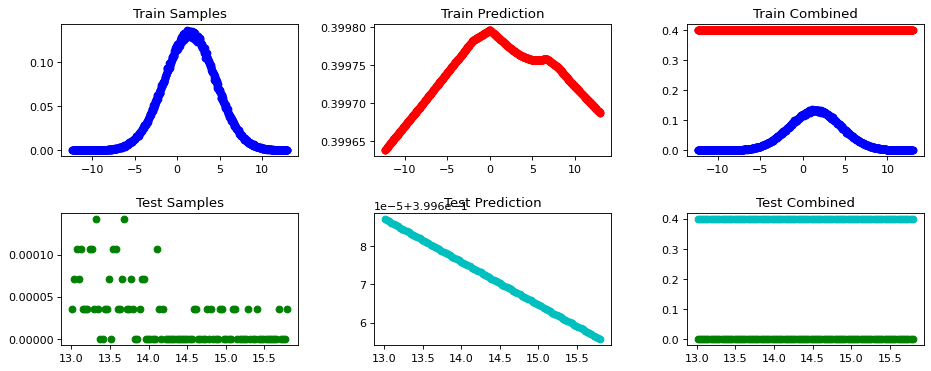

In [18]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), dpi=80)

ax1.plot(x_train, y_train, 'o', color='b', label='Observation')
ax1.set_title("Train Samples")

ax2.plot(x_train, y_train_res, 'o', color='r')
ax2.set_title("Train Prediction")

ax3.plot(x_train, y_train, 'o', color='b', label='Observation')
ax3.plot(x_train, y_train_res, 'o', color='r')
ax3.set_title("Train Combined")

ax4.plot(x_test, y_test, 'o', color='g', label='Observation')
ax4.set_title("Test Samples")

ax5.plot(x_test, y_test_res, 'o', color='c')
ax5.set_title("Test Prediction")

ax6.plot(x_test, y_test, 'o', color='g', label='Observation')
ax6.plot(x_test, y_test_res, 'o', color='c')
ax6.set_title("Test Combined")

plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)
plt.show()